In [572]:
%load_ext autoreload
%autoreload 1

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import FileLink
import os
from IPython.display import clear_output, display

%aimport plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [573]:
output = widgets.Output()

vals = {
    'images': [None, None, None, None],  # [pred_gt, pred_gt2, default_gt, default_image]
    'processed_images': [None, None, None],  # [alg1, alg2, default]
    'selected_file': '01_Hanns_Klemm_Str_45_000002_000190.png',
    'selected_folder': 'Fishyscapes_LaF',
    'selected_algo': ['grood_knn_e2e_cityscapes_500k_fl003_condensv5_randomcrop1344_hflip_nptest_lr0025wd54_ipdf0_ioodpdf0uni1_staticood1',
                      'grood_knn_e2e_cityscapes_500k_fl003_condensv5_randomcrop1344_hflip_nptest_lr0025wd54_ipdf0_ioodpdf0uni1_staticood1'],
    'threshold': [0.8, 0.997] 
}

01_Hanns_Klemm_Str_45_00005_000230  
No ground truth

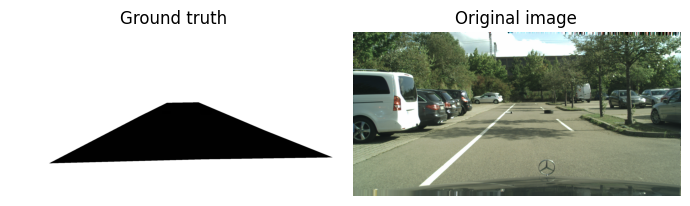

In [574]:
#Image preview

fig, ax = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns, and adjust the figure size as needed
#mask_gray = cv.cvtColor(original_gt, cv.COLOR_BGR2GRAY)

original_gt = plot.load_gt(vals['selected_file'], vals['selected_folder'], vals['selected_algo'][0], True)
original_image = plot.load_image(vals['selected_file'], vals['selected_folder'])


# Display the mask
ax[0].imshow(original_gt)
ax[0].set_title('Ground truth')
ax[0].axis('off')  

# Display the image
ax[1].imshow(original_image)
ax[1].set_title('Original image')
ax[1].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [575]:
def show_differance():
    wrong_color = [255, 0, 0]
    missed_color = [0, 255, 0]
    
    show_final(True, 3)
    
    
    road_mask, obstacle_mask = plot.create_mask(vals['images'][0], False, vals['threshold'])
    
    mask , mask1 = vals['images'][2], obstacle_mask
    mask2 = np.any(mask == 0, axis=-1)


    combined_image = np.zeros((1024, 2048, 3), dtype=np.uint8)


    # Set colors where booleans are different
    combined_image[(mask1 & ~mask2)] = wrong_color
    combined_image[(~mask1 & mask2)] = missed_color

    # Create black mask
    black_mask = np.all(combined_image == [0, 0, 0], axis=-1)


    grayscale_image = np.dot(original_image[..., :3], [0.299, 0.587, 0.114])
    grayscale_image_expanded = np.stack([grayscale_image]*3, axis=-1)



    # Create a copy of the combined image to add the grayscale image
    result_image = np.copy(combined_image)
    result_image[black_mask] = grayscale_image_expanded[black_mask]

    # Overlay the grayscale image in the regions where the combined image is black


    fig, ax = plt.subplots(1, 4,  figsize=(15, 12))  # 1 row, 3 columns, and adjust the figure size as needed
    ax[0].imshow(mask1)
    ax[0].set_title('Binary image')
    ax[0].axis('off')  # Hide axes

    ax[1].imshow(combined_image)
    ax[1].set_title('Difference in binary images')
    ax[1].axis('off')  

    ax[2].imshow(grayscale_image)
    ax[2].set_title('Greyscale image')
    ax[2].axis('off')  

    ax[3].imshow(result_image)
    ax[3].set_title('Grayscale image with highlighted difference ')
    ax[3].axis('off')  

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

In [576]:
def draw_differance(id):
    
    # Mozna ziskat obstacle mask z draw conture/ overlay
    road_mask, obstacle_mask = plot.create_mask(vals['images'][id], False, vals['threshold'])
    
    wrong_color = [255, 0, 0]
    missed_color = [0, 255, 0]

    mask , mask1 = vals['images'][2], obstacle_mask
    mask2 = np.any(mask == 0, axis=-1)

    # BUG HARDCODED SIZE
    combined_image = np.zeros((mask1.shape[0], mask1.shape[1], 3), dtype=np.uint8)

    # Set colors where booleans are different
    combined_image[(mask1 & ~mask2)] = wrong_color
    combined_image[(~mask1 & mask2)] = missed_color

    # Create black mask
    black_mask = np.all(combined_image == [0, 0, 0], axis=-1)

    grayscale_image = np.dot(vals['images'][3][..., :3], [0.299, 0.587, 0.114])
    grayscale_image_expanded = np.stack([grayscale_image]*3, axis=-1)

    # Create a copy of the combined image to add the grayscale image
    result_image = np.copy(combined_image)
    result_image[black_mask] = grayscale_image_expanded[black_mask]

    return result_image

In [577]:
def process_default(img, gt, use_dataset = True):
    #print(use_dataset)
    thresh = vals['threshold']
    
    contoured_image = plot.drawContours(img, gt, use_dataset, thresh)
    overlay_50 = plot.drawOverlay(0.5, img, gt, use_dataset, thresh)
    overlay_100 = plot.drawOverlay(1, img, gt, use_dataset, thresh)
    return np.concatenate((contoured_image, overlay_50, overlay_100), axis=1)

In [578]:
def process_pred(img, gt, id):
    
    four_imgs_in_one = np.concatenate((process_default(img, gt, False), draw_differance(id)   ), axis=1)


    return four_imgs_in_one

In [579]:
def show_final(new_gt, id, fig_size=(16, 12)):
    
    # změna slideru = ulozeny #2 (ctyrty obrazek) a default zustanou stejne, nacteni #1 jen metod na kresleni       show_final(False, 0)
    # změna metody = ulozeny #1 a default zustane stejny, nacteni gt noveho + metody kresleni                       show_final(True, 1)
    # změna filu = nacteni novych obrazku + gt + metod kresleni u všech obrázků (id 3)                              show_final(True/False, 2)
    
    global vals
    

    # New files for everything
    if id > 1:
        selected_file = vals['selected_file']
        selected_folder = vals['selected_folder']

        vals['images'][0] = plot.load_gt(selected_file, selected_folder, vals['selected_algo'][0], False)
        vals['images'][1] = plot.load_gt(selected_file, selected_folder, vals['selected_algo'][1], False)
        vals['images'][2] = plot.load_gt(selected_file, selected_folder, vals['selected_algo'][1], True)
        vals['images'][3] = plot.load_image(selected_file, selected_folder)

        vals['processed_images'][0] = process_pred(vals['images'][3], vals['images'][0], 0)
        vals['processed_images'][1] = process_pred(vals['images'][3], vals['images'][1], 1)
        vals['processed_images'][2] = np.concatenate((process_default(vals['images'][3], vals['images'][2]), vals['images'][3]) , axis=1)
    
    # New process / gt + process for selected image 
    else:
        # Process image with new gt with ID
        if new_gt:
            vals['images'][id] = plot.load_gt(vals['selected_file'], vals['selected_folder'], vals['selected_algo'][id], False)
            vals['processed_images'][id] = process_pred(vals['images'][3], vals['images'][id], id)
        # Process with old gt with ID 
        else:
            vals['processed_images'][id] = process_pred(vals['images'][3], vals['images'][id], id)

    final_image = np.concatenate((vals['processed_images'][2], vals['processed_images'][0], vals['processed_images'][1]), axis=0)  # combined alg1 and default
    
    with output:
        clear_output(wait=True)
        plt.figure(figsize=fig_size)
        plt.imshow(final_image)
        plt.axis('off')
        plt.title('Contours and Overlays')
        plt.show()


In [580]:
def on_folder_selected(change):
    global vals
    vals['selected_folder'] = change['new']
    # Update the image selector options based on the selected folder
    image_selector_widget.options = plot.get_all_files(f'data/export/datasets/{vals["selected_folder"]}/test/imgs/')

In [581]:
def on_algo_selected(change, id):
    global vals    
    vals['selected_algo'][id] = change['new']
    # Show the image with the new model selected
    show_final(True, id)

In [582]:
def on_file_selected(change):
    global vals
    vals['selected_file'] = change['new']
    # Show the image with the new file selected
    show_final(True, 3)

In [583]:
def update_slider(change, id):
    global vals
    
    
    if(id == 0):
        vals['threshold'] = [road_slider0.value, obstacle_slider0.value]
    
    else:
        vals['threshold'] = [road_slider1.value, obstacle_slider1.value]
    
    # Show the image with the updated slider values
    show_final(False, id)

In [584]:
def save_image(b):
    
    # Create 'output' directory if it doesn't exist
    output_dir = 'output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define the filename with the 'output' directory
    filename = os.path.join(output_dir, 'combined_image.png')
    
    final_rgb = np.concatenate((vals['processed_images'][2], vals['processed_images'][0], vals['processed_images'][1]), axis=0)[:, :, [2, 1, 0]]
    
    cv.imwrite(filename, final_rgb)
    display(FileLink(filename))

# Create a save button
save_button = widgets.Button(description="Save Image") 
save_button.on_click(save_image)

/home/jiri/widgets-CVUT/output/combined_image.png

/home/jiri/widgets-CVUT/output/combined_image.png

/home/jiri/widgets-CVUT/output/combined_image.png

In [585]:


road_slider0 = widgets.FloatSlider(value=vals['threshold'][0], min=0.4, max=0.9995, step=0.0001, description='Road Threshold', readout_format='.4f',
                                  style={'description_width': 'initial'}, layout=widgets.Layout(width='500px'))
road_slider0.observe(lambda change:update_slider(change, 0), names='value')

obstacle_slider0 = widgets.FloatSlider(value=vals['threshold'][1], min=0.95, max=1, step=0.0001, description='Obstacle Threshold', readout_format='.4f', 
                                      style={'description_width': 'initial'}, layout=widgets.Layout(width='500px'))
obstacle_slider0.observe(lambda change:update_slider(change, 0), names='value')


road_slider1 = widgets.FloatSlider(value=vals['threshold'][0], min=0.4, max=0.9995, step=0.0001, description='Road Threshold', readout_format='.4f',
                                  style={'description_width': 'initial'}, layout=widgets.Layout(width='500px'))
road_slider1.observe(lambda change:update_slider(change, 1), names='value')

obstacle_slider1 = widgets.FloatSlider(value=vals['threshold'][1], min=0.95, max=1, step=0.0001, description='Obstacle Threshold', readout_format='.4f', 
                                      style={'description_width': 'initial'}, layout=widgets.Layout(width='500px'))
obstacle_slider1.observe(lambda change:update_slider(change, 1), names='value')

folder_selector_widget = widgets.Dropdown(
    options=plot.get_all_folders('data/export/datasets/'),  # Call the folder-only function
    description='Choose folder',
    disabled=False,
    style={'description_width': 'initial'}, layout=widgets.Layout(width='500px')
)
folder_selector_widget.observe(on_folder_selected, names='value')

image_selector_widget = widgets.Dropdown(
    options=plot.get_all_files('data/export/datasets/' + vals['selected_folder'] + '/test/imgs/'),
    description='Choose file',
    disabled=False,
    style={'description_width': 'initial'}, layout=widgets.Layout(width='500px')
)
image_selector_widget.observe(on_file_selected, names='value')

algo_selector_widget0 = widgets.Dropdown(
    options=plot.get_all_folders('data/export/results/'),
    description='Choose Algorithm 0',
    disabled=False,
    style={'description_width': 'initial'}, layout=widgets.Layout(width='500px')
)
algo_selector_widget0.observe(lambda change: on_algo_selected(change, 0), names='value')

algo_selector_widget1 = widgets.Dropdown(
    options=plot.get_all_folders('data/export/results/'),
    description='Choose Algorithm 1',
    disabled=False,
    style={'description_width': 'initial'}, layout=widgets.Layout(width='500px')
)
algo_selector_widget1.observe(lambda change: on_algo_selected(change, 1), names='value')

 

display(folder_selector_widget, image_selector_widget, algo_selector_widget0, algo_selector_widget1, road_slider0, obstacle_slider0, road_slider1, obstacle_slider1, output, save_button)
show_final(True, 3)


Dropdown(description='Choose folder', layout=Layout(width='500px'), options=('RoadObstacles21', 'RoadAnomaly',…

Dropdown(description='Choose file', layout=Layout(width='500px'), options=('01_Hanns_Klemm_Str_45_000005_00023…

Dropdown(description='Choose Algorithm 0', layout=Layout(width='500px'), options=('grood_logml_1000K_01adamw_t…

Dropdown(description='Choose Algorithm 1', layout=Layout(width='500px'), options=('grood_logml_1000K_01adamw_t…

FloatSlider(value=0.8, description='Road Threshold', layout=Layout(width='500px'), max=0.9995, min=0.4, readou…

FloatSlider(value=0.997, description='Obstacle Threshold', layout=Layout(width='500px'), max=1.0, min=0.95, re…

FloatSlider(value=0.8, description='Road Threshold', layout=Layout(width='500px'), max=0.9995, min=0.4, readou…

FloatSlider(value=0.997, description='Obstacle Threshold', layout=Layout(width='500px'), max=1.0, min=0.95, re…

Output()

Button(description='Save Image', style=ButtonStyle())